# Library

In [1]:
%matplotlib inline
import datetime
timeformat = "%Y-%m-%d %H:%M:%S"

from sklearn import neural_network
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import plotly.plotly as py
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams['figure.figsize'] = [16.0, 8.0]
colors = {'MLP':'C3', 'RT':'C2', 'LR':'C1', 'Real':'C0'}

# Global

In [2]:
predict = dict()
predict['datetime'], predict['RT'], predict['LR'], predict['MLP'] = [], [], [], []
rmse = dict()
rmse['datetime'], rmse['RT'], rmse['LR'], rmse['MLP'] = [], [], [], []
importances = pd.DataFrame()
coefficients = pd.DataFrame()

# Function

# Data preprocess

In [3]:
pm25 = pd.read_csv("../data/Erlin.csv", parse_dates=True)[['PM2.5']]

In [4]:
date_feature = pd.read_csv("../data/date_feature.csv", parse_dates=True)
time_series = pd.read_csv("../data/pm2.5_timeseries.csv", parse_dates=True)
meteorology = pd.read_csv("../data/Erlin_minmax.csv", parse_dates=True)

time_series = time_series[[column for column in time_series.columns if column not in ['datetime']]]
time_series = time_series[['t-'+str(x+1) for x in range(12)]]
meteorology = meteorology[['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED']]

## to forecast PM2.5(t), we use RAINFALL(t-1) instead of RAINFALL(t)
## cause we could not know RAINFALL(t) from weather forecast
meteorology.RAINFALL = meteorology.RAINFALL.shift()

data = pd.concat([pm25, meteorology, time_series, date_feature], axis=1)

target = "PM2.5"
exclude = ['datetime', target]
features = [f for f in data.columns if f not in exclude]

# Training

In [5]:
start_time = time.time()

DateStart = '2016-12-01 00:00:00'
DateEnd = '2016-12-31 00:00:00'
TrainStart = data[data.datetime.values == '2016-01-01 00:00:00'].index[0]
regs = ['RT', 'LR', 'MLP']
now = datetime.datetime.strptime(DateStart, timeformat)
lastday =datetime.datetime.strptime(DateEnd, timeformat)

delta = datetime.timedelta(days=1)

while now < lastday:
    
    ## new iteration, train new model.
    y_start = now.strftime("%Y-%m-%d %H:%M:%S")
    now += delta
    y_end = now.strftime("%Y-%m-%d %H:%M:%S")
    print 'Time Period: ', y_start, '~', y_end
    
    start = data[data.datetime.values == y_start].index[0]
    end = data[data.datetime.values == y_end].index[0]
    
    train = data[TrainStart:start].dropna()
    test = data[start:end]
    
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    y_predict = dict()
    ## Regression Tree
    RT = AdaBoostRegressor(DecisionTreeRegressor())
    RT.fit(X_train, y_train)
    '''
    zipped = sorted(zip(features, RT.feature_importances_), key = lambda imp: imp[1])
    print 'Feature : Importances'
    for f, imp in zipped:
        print f, ':', imp
    '''
    imps = pd.DataFrame(dict(list(zip(features, RT.feature_importances_))), index=[0])
    importances = pd.concat([importances, imps], axis=0, ignore_index=True)

    y_predict['RT'] = RT.predict(X_test)

    ## Linear Regression
    LR = linear_model.LinearRegression()
    LR.fit(X_train, y_train)
    '''
    zipped = sorted(zip(features, LR.coef_), key = lambda coef: coef[1])
    print 'Feature : Coefficients'
    for f, coef in zipped:
        print f, ':', coef
    '''
    coefs = pd.DataFrame(dict(list(zip(features, LR.coef_))), index=[0])
    coefficients = pd.concat([coefficients, coefs], axis=0, ignore_index=True)
    
    y_predict['LR'] = LR.predict(X_test)

    ## MLP Regression
    MLP = neural_network.MLPRegressor(activation='relu')
    MLP.fit(X_train, y_train)
    '''print 'Model: \n', MLP'''

    y_predict['MLP'] = MLP.predict(X_test) 
    
    ## Measure
    predict['datetime'].extend(test.datetime.tolist())
    rmse['datetime'].append(y_start)
    
    
    for method in regs:
        predict[method].extend(y_predict[method].tolist())
        rmse[method].append(sqrt(mean_squared_error(y_predict[method], y_test)))
    
    ## end
end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

Time Period:  2016-12-01 00:00:00 ~ 2016-12-02 00:00:00


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Time Period:  2016-12-02 00:00:00 ~ 2016-12-03 00:00:00
Time Period:  2016-12-03 00:00:00 ~ 2016-12-04 00:00:00
Time Period:  2016-12-04 00:00:00 ~ 2016-12-05 00:00:00
Time Period:  2016-12-05 00:00:00 ~ 2016-12-06 00:00:00
Time Period:  2016-12-06 00:00:00 ~ 2016-12-07 00:00:00
Time Period:  2016-12-07 00:00:00 ~ 2016-12-08 00:00:00
Time Period:  2016-12-08 00:00:00 ~ 2016-12-09 00:00:00
Time Period:  2016-12-09 00:00:00 ~ 2016-12-10 00:00:00
Time Period:  2016-12-10 00:00:00 ~ 2016-12-11 00:00:00
Time Period:  2016-12-11 00:00:00 ~ 2016-12-12 00:00:00
Time Period:  2016-12-12 00:00:00 ~ 2016-12-13 00:00:00
Time Period:  2016-12-13 00:00:00 ~ 2016-12-14 00:00:00
Time Period:  2016-12-14 00:00:00 ~ 2016-12-15 00:00:00
Time Period:  2016-12-15 00:00:00 ~ 2016-12-16 00:00:00
Time Period:  2016-12-16 00:00:00 ~ 2016-12-17 00:00:00
Time Period:  2016-12-17 00:00:00 ~ 2016-12-18 00:00:00
Time Period:  2016-12-18 00:00:00 ~ 2016-12-19 00:00:00
Time Period:  2016-12-19 00:00:00 ~ 2016-12-20 0

In [6]:
df_prdict = pd.DataFrame(predict)
df_rmse = pd.DataFrame(rmse)

real = data[data[data.datetime.values == DateStart].index[0] 
     : data[data.datetime.values == DateEnd].index[0]]['PM2.5'].tolist()
datetime = data[data[data.datetime.values == DateStart].index[0] 
     : data[data.datetime.values == DateEnd].index[0]]['datetime'].tolist()

# Measure

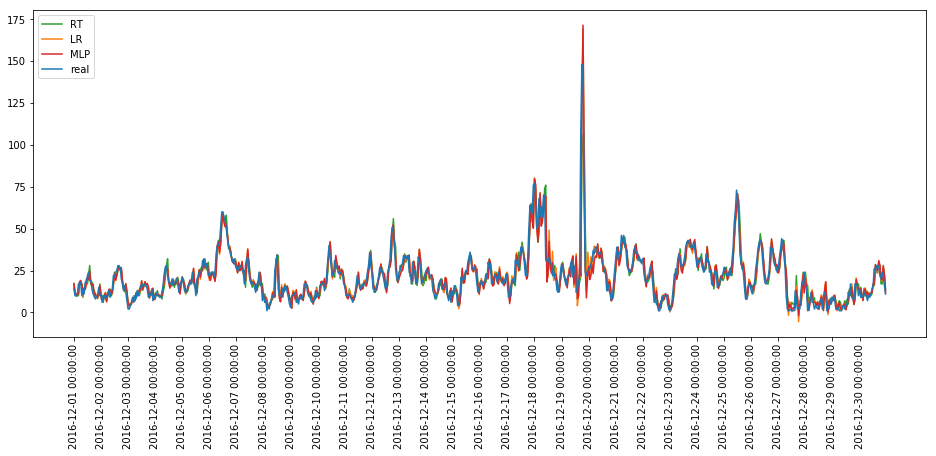

In [22]:
for reg in regs:
    plt.plot(df_prdict[reg], colors[reg], label = reg)

plt.xticks(range(0,len(df_prdict['MLP']),24), datetime[::24])
plt.xticks(rotation=90)
plt.plot(real, colors['Real'], label = 'real')
plt.legend(loc='upper left')
plt.show()

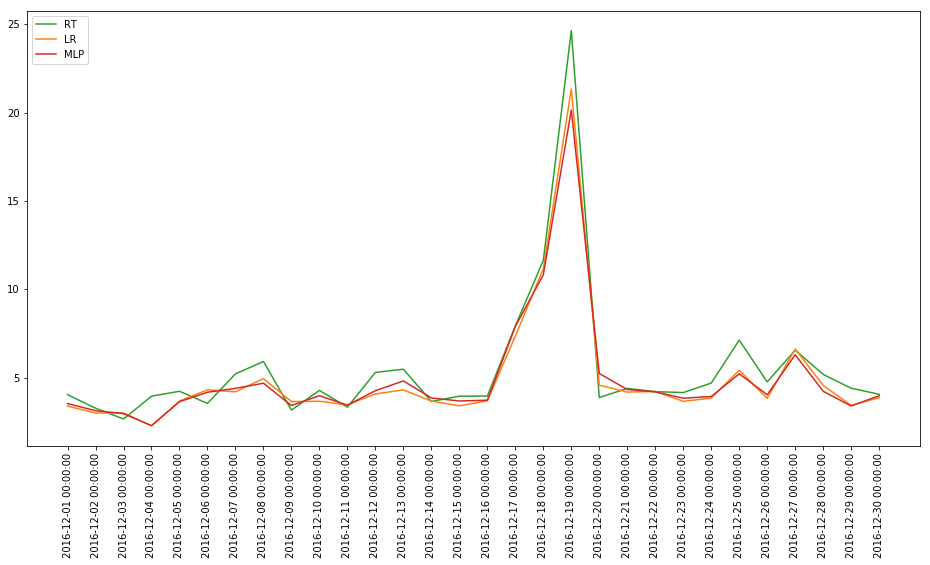

In [23]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
for reg in regs:
    plt.plot(df_rmse[reg], colors[reg], label=reg)
plt.xticks(range(len(df_rmse['MLP'])), datetime[::24])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

# Plot

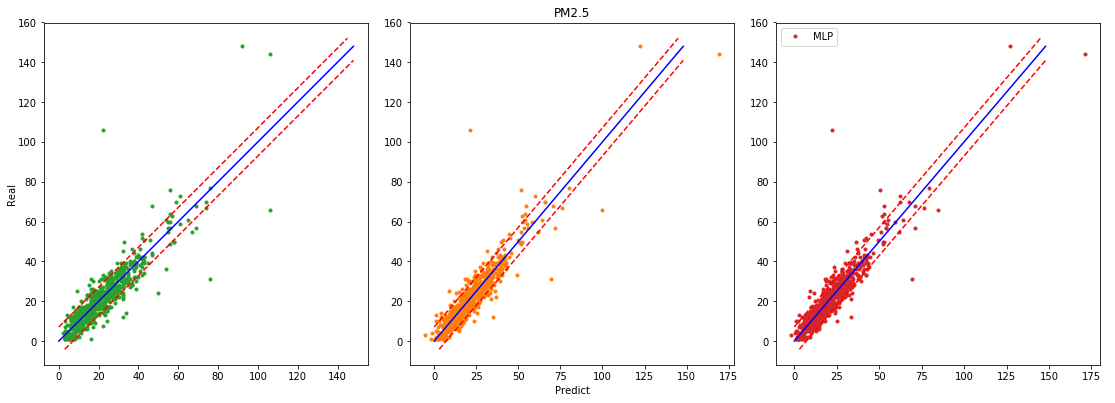

In [9]:
plt.rcParams['figure.figsize'] = [16.0, 6.0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.title.set_text(target)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Predict')
ax.set_ylabel('Real')

subplot = {'RT':131, 'LR':132, 'MLP':133}
for reg in regs:
    sub_ax = fig.add_subplot(subplot[reg])
    sub_ax.plot(df_prdict[reg], real, colors[reg] + '.', label=reg)
    
    a, b = 0, max(max(real), 24)
    mrange = 5 * sqrt(2)
    sub_ax.plot([a, b], [a, b], 'b-')
    sub_ax.plot([a, b - 3], [a+mrange, b+mrange -3], 'r--')
    sub_ax.plot([a + 3, b], [a-mrange + 3, b-mrange], 'r--')
    
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Output

In [10]:
importances

AMB_TEMP  RAINFALL        RH  WIND_SPEED    hour_0    hour_1   hour_10  \
0   0.004002  0.000558  0.003433    0.004380  0.000124  0.000103  0.000222   
1   0.005691  0.001158  0.005187    0.005574  0.000136  0.000150  0.000234   
2   0.003739  0.000593  0.004004    0.005079  0.000174  0.000122  0.000175   
3   0.004141  0.000600  0.004221    0.005864  0.000139  0.000139  0.000229   
4   0.004601  0.000843  0.003673    0.010172  0.000208  0.000103  0.000221   
5   0.004719  0.000508  0.002950    0.004353  0.000129  0.000086  0.000229   
6   0.003761  0.000584  0.006967    0.005179  0.000175  0.000113  0.000205   
7   0.005790  0.000560  0.008742    0.003897  0.000118  0.000167  0.000191   
8   0.003428  0.000524  0.002506    0.004719  0.000092  0.000098  0.000185   
9   0.006023  0.001141  0.005885    0.009475  0.000155  0.000123  0.000239   
10  0.005748  0.000605  0.003789    0.011812  0.000134  0.000097  0.000191   
11  0.004859  0.000633  0.003403    0.007567  0.000128  0.000110  0.000190   
12  0.004969  0.000805  0.003524    0.005150  0.000113  0.000112  0.000205   
13  0.003803  0.000847  0.003519    0.005309  0.000134  0.000146  0.000247   
14  0.004816  0.000535  0.004177    0.005964  0.000145  0.000113  0.000281   
15  0.003710  0.000737  0.003388    0.005396  0.000121  0.000109  0.000197   
16  0.003645  0.001124  0.002787    0.004492  0.000128  0.000123  0.000176   
17  0.005127  0.000539  0.005073    0.007409  0.000132  0.000095  0.000195   
18  0.005707  0.000642  0.003808    0.009348  0.000123  0.000129  0.000293   
19  0.004439  0.000849  0.005303    0.005881  0.000107  0.000117  0.000340   
20  0.004036  0.000700  0.005521    0.005883  0.000158  0.000101  0.000321   
21  0.007227  0.000515  0.007868    0.005700  0.000135  0.000103  0.000527   
22  0.004955  0.000768  0.006768    0.007602  0.000110  0.000117  0.000310   
23  0.004073  0.001665  0.004850    0.006741  0.000149  0.000134  0.000334   
24  0.004629  0.000583  0.003654    0.006202  0.000115  0.000137  0.000327   
25  0.004647  0.000616  0.009858    0.007788  0.000119  0.000139  0.000341   
26  0.005286  0.000760  0.007524    0.006529  0.000177  0.000118  0.000254   
27  0.003974  0.000551  0.003353    0.006150  0.000121  0.000093  0.000218   
28  0.005034  0.000757  0.005045    0.005215  0.000126  0.000122  0.000354   
29  0.004057  0.000745  0.005073    0.003935  0.000108  0.000104  0.000249   

     hour_11   hour_12   hour_13    ...           t-7       t-8       t-9  \
0   0.000491  0.000280  0.000184    ...      0.002423  0.007470  0.012804   
1   0.000368  0.000183  0.001895    ...      0.003812  0.007879  0.004663   
2   0.000393  0.000185  0.000126    ...      0.003168  0.009758  0.003390   
3   0.000508  0.000333  0.000161    ...      0.003073  0.009773  0.009241   
4   0.000358  0.000197  0.000139    ...      0.004102  0.003881  0.009783   
5   0.000354  0.000160  0.000102    ...      0.002475  0.006056  0.003537   
6   0.000374  0.000165  0.000158    ...      0.002656  0.007113  0.006010   
7   0.000334  0.000159  0.000136    ...      0.002680  0.004930  0.003525   
8   0.000335  0.000183  0.000121    ...      0.003035  0.009533  0.012863   
9   0.000439  0.000228  0.000245    ...      0.003463  0.006426  0.006957   
10  0.000295  0.000161  0.000126    ...      0.003249  0.006725  0.008289   
11  0.000274  0.000195  0.000137    ...      0.002634  0.006159  0.012179   
12  0.000339  0.000253  0.000212    ...      0.002717  0.005564  0.006275   
13  0.000335  0.000208  0.000134    ...      0.003953  0.011432  0.003873   
14  0.000336  0.000260  0.000177    ...      0.002888  0.007743  0.007402   
15  0.000261  0.000204  0.000141    ...      0.003022  0.007285  0.008801   
16  0.000447  0.000179  0.000174    ...      0.002970  0.008617  0.004197   
17  0.000389  0.000225  0.000129    ...      0.002015  0.008939  0.011859   
18  0.000359  0.000263  0.000135    ...      0.002174  0.008844  0.010774   
19  0.000323  0.000157  0.000190    ...      

In [11]:
coefficients

AMB_TEMP   RAINFALL        RH  WIND_SPEED    hour_0    hour_1   hour_10  \
0  -3.623099 -23.024258 -1.371998   -5.125839 -0.505736 -0.572841  0.336826   
1  -3.640040 -23.010063 -1.380183   -5.138184 -0.514316 -0.576368  0.352215   
2  -3.635738 -23.014751 -1.384820   -5.142220 -0.508816 -0.579949  0.356306   
3  -3.684895 -22.991569 -1.408529   -5.152328 -0.515421 -0.581696  0.363291   
4  -3.680694 -22.992695 -1.401568   -5.159182 -0.520742 -0.582483  0.366821   
5  -3.645388 -23.009169 -1.384552   -5.133405 -0.520506 -0.584727  0.338360   
6  -3.510526 -22.798376 -1.456631   -5.020423 -0.501659 -0.564607  0.342881   
7  -3.551374 -22.814113 -1.442516   -5.003155 -0.505112 -0.550546  0.335818   
8  -3.595173 -22.811113 -1.462419   -5.019938 -0.498070 -0.561353  0.386575   
9  -3.613021 -22.859610 -1.444996   -4.991575 -0.506886 -0.538637  0.386712   
10 -3.630308 -22.858867 -1.444806   -5.001357 -0.512748 -0.533479  0.407756   
11 -3.650417 -22.853973 -1.451529   -5.013697 -0.513439 -0.549927  0.415420   
12 -3.660020 -22.750038 -1.523005   -5.063935 -0.514426 -0.558311  0.406786   
13 -3.658681 -22.767034 -1.516037   -5.065986 -0.509909 -0.559342  0.412996   
14 -3.673987 -22.799790 -1.500298   -5.070298 -0.502979 -0.555445  0.416637   
15 -3.677706 -22.798642 -1.512656   -5.061940 -0.507625 -0.552647  0.420013   
16 -3.673814 -22.814334 -1.512870   -5.039110 -0.505703 -0.555894  0.402099   
17 -3.645650 -22.859550 -1.464001   -5.081247 -0.531066 -0.581941  0.403539   
18 -3.718153 -23.145364 -1.448107   -5.100417 -0.540452 -0.611673  0.311885   
19 -3.757373 -23.486150 -1.505073   -5.242068 -0.545236 -0.638941  0.285716   
20 -3.783611 -23.505562 -1.525440   -5.227097 -0.549939 -0.621898  0.293430   
21 -3.728981 -23.589144 -1.454958   -5.232337 -0.541664 -0.607147  0.276107   
22 -3.810227 -23.618578 -1.460124   -5.236424 -0.533566 -0.631958  0.269449   
23 -3.758174 -23.446817 -1.559827   -5.217124 -0.525811 -0.628787  0.251920   
24 -3.784171 -23.510962 -1.524278   -5.207267 -0.534619 -0.616891  0.265835   
25 -3.809582 -23.425368 -1.577649   -5.284004 -0.526977 -0.619247  0.281284   
26 -3.786448 -23.336286 -1.621308   -5.319667 -0.529763 -0.624107  0.260126   
27 -3.812397 -23.245121 -1.684785   -5.380013 -0.519788 -0.605341  0.241217   
28 -3.769586 -23.531101 -1.680077   -5.383701 -0.530141 -0.609462  0.238850   
29 -3.773419 -23.540837 -1.664165   -5.403291 -0.526115 -0.606391  0.241206   

     hour_11   hour_12   hour_13    ...           t-7       t-8       t-9  \
0   0.827013  0.503127 -0.616649    ...      0.312403 -0.032670 -0.128960   
1   0.831869  0.510689 -0.600490    ...      0.312346 -0.032732 -0.128799   
2   0.845723  0.505305 -0.587138    ...      0.312391 -0.032634 -0.128818   
3   0.858088  0.497380 -0.573591    ...      0.312166 -0.032252 -0.128830   
4   0.847186  0.496807 -0.566469    ...      0.312515 -0.032418 -0.128691   
5   0.849217  0.482906 -0.546416    ...      0.313292 -0.032392 -0.128635   
6   0.839703  0.455266 -0.569319    ...      0.313968 -0.032672 -0.128920   
7   0.833065  0.457558 -0.566336    ...      0.314134 -0.032086 -0.130006   
8   0.838117  0.460580 -0.595211    ...      0.314367 -0.031697 -0.130757   
9   0.849813  0.480627 -0.595957    ...      0.312832 -0.029380 -0.131753   
10  0.831564  0.473108 -0.587384    ...      0.312655 -0.028763 -0.132723   
11  0.846738  0.457703 -0.580852    ...      0.311608 -0.028039 -0.132520   
12  0.827376  0.450873 -0.572208    ...      0.311986 -0.028336 -0.132218   
13  0.816258  0.480826 -0.587432    ...      0.312659 -0.027914 -0.132489   
14  0.830284  0.483831 -0.575595    ...      0.313034 -0.027430 -0.133947   
15  0.831957  0.480889 -0.557892    ...      0.313033 -0.027574 -0.134199   
16  0.833725  0.492399 -0.563860    ...      0.313587 -0.027825 -0.134063   
17  0.842526  0.500732 -0.564185    ...      0.314588 -0.027128 -0.135903   
18  0.892302  0.528436 -0.592059    ...      0.308377 -0.015706 -0.140144   
19  0.948044  

In [12]:
df_rmse

LR        MLP         RT             datetime
0    3.406290   3.543534   4.049105  2016-12-01 00:00:00
1    3.011265   3.142432   3.285111  2016-12-02 00:00:00
2    3.016521   2.977404   2.674650  2016-12-03 00:00:00
3    2.290063   2.294658   3.961110  2016-12-04 00:00:00
4    3.685020   3.652485   4.242641  2016-12-05 00:00:00
5    4.323956   4.186529   3.554633  2016-12-06 00:00:00
6    4.213147   4.405571   5.224143  2016-12-07 00:00:00
7    4.956308   4.697323   5.924725  2016-12-08 00:00:00
8    3.659092   3.433220   3.175108  2016-12-09 00:00:00
9    3.678025   3.992415   4.290554  2016-12-10 00:00:00
10   3.472650   3.455227   3.343215  2016-12-11 00:00:00
11   4.091565   4.274223   5.306901  2016-12-12 00:00:00
12   4.318175   4.824525   5.489573  2016-12-13 00:00:00
13   3.686875   3.863763   3.664298  2016-12-14 00:00:00
14   3.416257   3.692138   3.963666  2016-12-15 00:00:00
15   3.700850   3.735820   3.970306  2016-12-16 00:00:00
16   7.362817   7.905724   7.933826  2016-12-17 00:00:00
17  11.169741  10.827582  11.644670  2016-12-18 00:00:00
18  21.337760  20.146170  24.643817  2016-12-19 00:00:00
19   4.585495   5.243996   3.886408  2016-12-20 00:00:00
20   4.197137   4.341050   4.403807  2016-12-21 00:00:00
21   4.229895   4.209896   4.219511  2016-12-22 00:00:00
22   3.672295   3.849521   4.168333  2016-12-23 00:00:00
23   3.856216   3.945082   4.705670  2016-12-24 00:00:00
24   5.431686   5.228850   7.133401  2016-12-25 00:00:00
25   3.834113   4.043001   4.774062  2016-12-26 00:00:00
26   6.631846   6.308876   6.567756  2016-12-27 00:00:00
27   4.574252   4.239594   5.194299  2016-12-28 00:00:00
28   3.443967   3.409855   4.413259  2016-12-29 00:00:00
29   3.877204   3.990087   4.071305  2016-12-30 00:00:00

In [13]:
importances.to_csv('../output/RT_importances.csv', index=False)

In [14]:
coefficients.to_csv('../output/LR_coefficients.csv', index=False)

In [ ]:
df_rmse.to_csv('../output/rmse.csv', index=False)